In [116]:
import numpy as np
import torch 
import torch.nn as nn
import torch.nn.functional as F
import new_alg_v2 as na2
import matplotlib.pyplot as plt
import math
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
from tqdm import tqdm
import torch.optim as optim
torch.set_default_dtype(torch.float64)

In [117]:
def define_dataloaders(n_examples_train, n_examples_test, batch_size, classes=np.arange(10), zscore_images=True):
    # MNIST data, batch training
    #batch_size = n_examples_train

    # Choose the classes (at most 10)
    assert max(classes) <= 9

    # Transformation for the images
    transform = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize((0.5,), (0.5,)),
                                  ])
    trainset = MNIST(data_dir, download=True, train=True, transform=transform)
    testset = MNIST(data_dir, download=True, train=False, transform=transform)

    # Obtain training and test data. 
    # Note that both datasets are sorted, but the train and test loaders will shuffle them during training.
    n_examples_tt = [n_examples_train, n_examples_test]
    for i_d, (n_examples_i, dataset) in enumerate(zip(n_examples_tt, [trainset, testset])):
        n_per_class = n_examples_i // len(classes)
        data_orig = dataset.data.detach().clone()
        targets_orig = dataset.targets.detach().clone()
        for i_c, class_i in enumerate(classes):
            mask = targets_orig == class_i
            i0 = i_c * n_per_class
            i1 = (i_c+1) * n_per_class
            dataset.data[i0:i1] = data_orig[mask][:n_per_class]
            dataset.targets[i0:i1] = targets_orig[mask][:n_per_class]
        # Fill the remaining slots with random classes from the available choices
        n_remain = n_examples_i - i1 
        for i in range(n_remain):
            class_i = np.random.choice(classes)
            mask = targets_orig == class_i
            idx_i = np.random.choice(torch.where(mask)[0].cpu())
            dataset.data[i1+i] = data_orig[idx_i]
            dataset.targets[i1+i] = targets_orig[idx_i]

        # Cut off
        dataset.data = dataset.data[:n_examples_i]
        dataset.targets = dataset.targets[:n_examples_i]

    # Batch-loader
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
    testloader = torch.utils.data.DataLoader(testset, batch_size=n_examples_test, shuffle=False, num_workers=0)

    return trainloader, testloader

In [136]:
data_dir = '/files/'
batch_size = 512

#n_examples_train = 1*batch_size
#n_examples_test = 1*batch_size
#trainloader, testloader =  define_dataloaders(n_examples_train, n_examples_test, batch_size)
#testloader = trainloader

# Transformation for the images
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
trainset = MNIST(data_dir, download=True, train=True, transform=transform)
testset = MNIST(data_dir, download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

In [119]:
def calc_output_dim(input_H, input_W, kernel_size, pooling):

    # calc the parameters of the conv1 out put:
    H_out_conv1= math.floor(input_H-kernel_size+1)
    W_out_conv1= math.floor(input_W-kernel_size+1)

    # calc the dim after the pooling:
    pool_H_out= math.floor(((H_out_conv1-pooling)/pooling)+1)
    pool_W_out= math.floor(((W_out_conv1-pooling)/pooling)+1)

    # calc the parameters of the conv2 out put:
    H_out_conv2= math.floor(pool_H_out-kernel_size+1)
    W_out_conv2= math.floor(pool_W_out-kernel_size+1)

    # calc the dim after the pooling:
    pool2_H_out= math.floor(((H_out_conv2-pooling)/pooling)+1)
    pool2_W_out= math.floor(((W_out_conv2-pooling)/pooling)+1)

    # clac the dim of nn.Linear
    final_dim=pool2_H_out*pool2_W_out
    return final_dim

In [120]:
class CNN(nn.Module):
    def __init__(self, n_ch, n_classes, final_dim):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(n_ch, 1, kernel_size=kern_size, bias=False)
        self.conv2 = nn.Conv2d(1, 1, kernel_size=kern_size, bias=False)
        self.fc1 = nn.Linear(final_dim, final_dim, bias=False)
        self.fc2= nn.Linear(final_dim, n_classes, bias=False)

    def forward(self, x):
        final_dim = self.fc1.in_features
        x =torch.tanh( F.max_pool2d(self.conv1(x),pool_size))
        x = torch.tanh(F.max_pool2d(self.conv2(x),pool_size))
        x = x.view(-1, final_dim)
        x = torch.tanh(self.fc1(x))
        x= self.fc2(x)
        return x

In [121]:
def train(net, eta, n_epoch, train_loader, optim_alg = 'NA'):
    if optim_alg == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=eta, momentum=0)
    elif optim_alg == 'ADAM':
        optimizer = optim.Adam(net.parameters(), lr=eta)
    elif optim_alg == 'NA':
        optimizer = na2.new_alg(net.parameters(), lr=eta)
    train_losses = []
    train_accuracy = []
    net.train()
    loss = nn.CrossEntropyLoss()
    for epoch in range(n_epoch):
        for j,(data,target) in enumerate(train_loader):
            optimizer.zero_grad()
            py_hat = net(data)
            objective = loss(py_hat, torch.flatten(target))
            train_losses.append(float(objective))
            objective.backward()
            optimizer.step()
            #if (j%50) == 0:
            correct = 0
            with torch.no_grad():
                output = net(data)
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()
            train_accuracy.append(100. * correct / batch_size)

    return train_losses, train_accuracy

In [122]:
def test(net, test_loader):
    loss = nn.CrossEntropyLoss()
    with torch.no_grad():
        for j,(data, target) in enumerate(test_loader):
            output = net(data)
            test_loss = loss(output, torch.flatten(target))

    return float(test_loss)

In [137]:
# parameters
n_s = 64 # number of sample
n_ch = 1 # number of input channels 
d0 = 28 # dim0 of input image
d1 = 28 # dim1 of input image
fc2_in= 10
n_epoch = 1
output_dim = n_s
kern_size=5
pool_size=2
n_classes = 10

In [125]:
def xl_calc_fullt_trained_nn(eta, n_ch, d0, d1, kern_size, pool_size, train_loader, test_loader, optim_alg):

    #define the net and save init params
    final_dim = calc_output_dim(d0, d1, kern_size, pool_size)
    network = CNN(n_ch, n_classes, final_dim)
    conv1_init = network.conv1.weight.clone()
    conv2_init = network.conv2.weight.clone()
    fc1_init = network.fc1.weight.clone()
    fc2_init = network.fc2.weight.clone()


    #train and save init and final loss
    initial_loss = test(network, test_loader)
    train_loss, train_accuracy = train(network, eta, n_epoch, train_loader, optim_alg)
    print("******done training*******")
    final_loss = test(network, test_loader)

    #save final net params
    conv1_final = network.conv1.weight.clone()
    conv2_final = network.conv2.weight.clone()
    fc1_final = network.fc1.weight.clone()
    fc2_final = network.fc2.weight.clone()

    #init weights conv1
    with torch.no_grad():
      network.conv1.weight[:] = conv1_init
    loss_conv1 = test(network, test_loader)
        
    #init weights conv2
    with torch.no_grad():
      network.conv1.weight[:] = conv1_final
      network.conv2.weight[:] = conv2_init
    loss_conv2 = test(network, test_loader)
    
    #init weights fc1
    with torch.no_grad():
      network.conv2.weight[:] = conv2_final
      network.fc1.weight[:] = fc1_init
    loss_fc1 = test(network, test_loader)

    #init weights fc2
    with torch.no_grad():
      network.fc1.weight[:] = fc1_final
      network.fc2.weight[:] = fc2_init

    loss_fc2 = test(network, test_loader)
    
    dL = final_loss - initial_loss
    #print("for lr =",  eta, ":")
    #print("  inital loss = ", initial_loss)
    #print("  final loss = ", final_loss)
    if dL == 0:
      #print("for lr =",  eta, ":")
      #print("   ***dL zero***")
      return
    
    Xl_conv1 = (final_loss - loss_conv1)/dL
    Xl_conv2 = (final_loss - loss_conv2)/dL
    Xl_fc1 = (final_loss-loss_fc1)/dL
    Xl_fc2 = (final_loss-loss_fc2)/dL

    return [Xl_conv1, Xl_conv2, Xl_fc1 ,Xl_fc2], train_loss, train_accuracy
    

In [126]:
# SGD
lr = 1e-2
final_dim = calc_output_dim(d0, d1, kern_size, pool_size)

network = CNN(n_ch, n_classes, final_dim)
Xls, train_loss, train_accuracy = xl_calc_fullt_trained_nn(lr, n_ch, d0, d1, kern_size, pool_size, trainloader, testloader, 'SGD')

******done training*******


1.329878361881836 0.6616035697954278 0.7607288190870481 0.7431549039253903
sum =  3.495365654689702


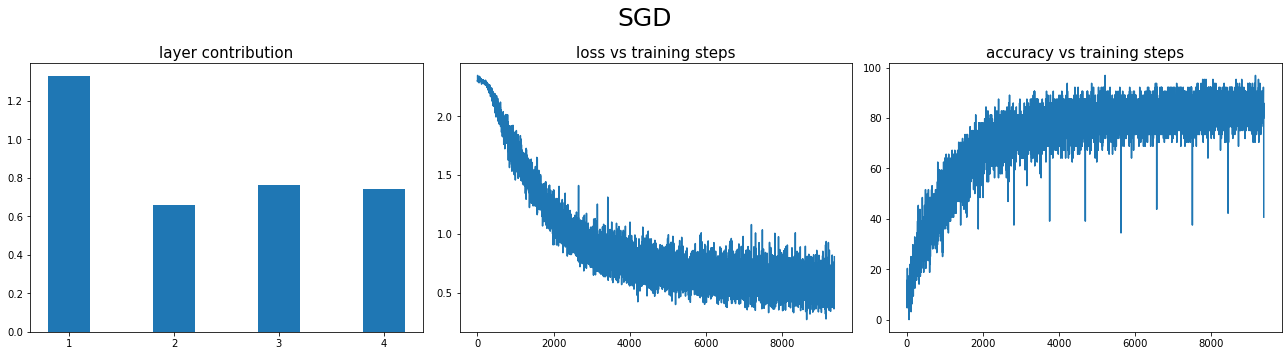

In [127]:
print(Xls[0], Xls[1], Xls[2], Xls[3])
sum = math.fsum(Xls)
print('sum = ', sum)

fig = plt.figure(figsize=(18, 5))
fig.suptitle('SGD', fontsize=25)

ax = fig.add_subplot(1,3,1)
ax.bar(['1','2','3','4'], [abs(Xls[0]), abs(Xls[1]), abs(Xls[2]) ,abs(Xls[3])], width = 0.4)
ax.set_title('layer contribution', fontsize=15)

x = list(range(len(train_loss)))
ax = fig.add_subplot(1,3,2)
plt.plot(x,train_loss)
ax.set_title('loss vs training steps', fontsize=15)

x = list(range(len(train_accuracy)))
ax = fig.add_subplot(1,3,3)
plt.plot(x,train_accuracy)
ax.set_title('accuracy vs training steps', fontsize=15)

plt.tight_layout()

In [145]:
# new alg
lr = 1e-2
network = CNN(n_ch, n_classes, final_dim)

Xls, train_loss, train_accuracy = xl_calc_fullt_trained_nn(lr, n_ch, d0, d1, kern_size, pool_size, trainloader, testloader, 'NA')

******done training*******


0.5275597460464722 0.40051785401709195 0.43121940780320467 0.32974798420273005
sum =  1.6890449920694988


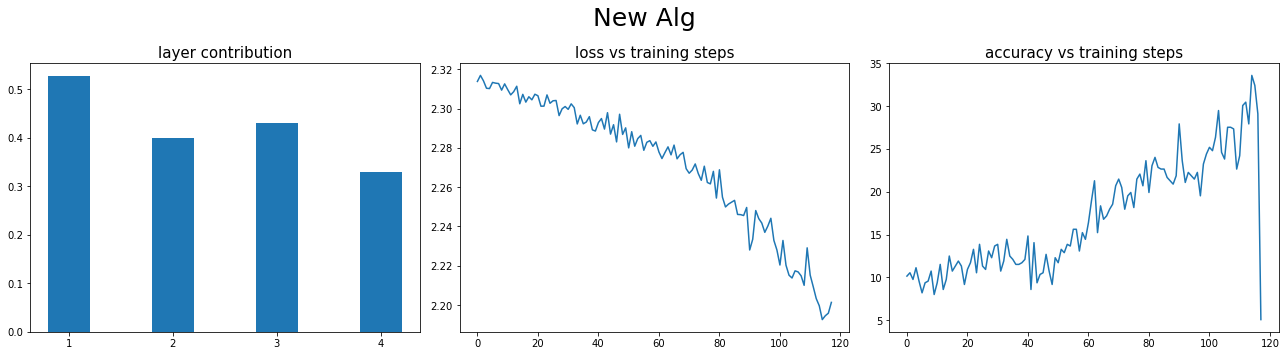

In [146]:
print(Xls[0], Xls[1], Xls[2], Xls[3])
sum = math.fsum(Xls)
print('sum = ', sum)

fig = plt.figure(figsize=(18, 5))
fig.suptitle('New Alg', fontsize=25)

ax = fig.add_subplot(1,3,1)
ax.bar(['1','2','3','4'], [abs(Xls[0]), abs(Xls[1]), abs(Xls[2]) ,abs(Xls[3])], width = 0.4)
ax.set_title('layer contribution', fontsize=15)

x = list(range(len(train_loss)))
ax = fig.add_subplot(1,3,2)
plt.plot(x,train_loss)
ax.set_title('loss vs training steps', fontsize=15)

x = list(range(len(train_accuracy)))
ax = fig.add_subplot(1,3,3)
plt.plot(x,train_accuracy)
ax.set_title('accuracy vs training steps', fontsize=15)

plt.tight_layout()

0.350620112567988 0.6318895980575725 0.4402078845863889 0.4368232107931685
sum =  1.8595408060051177


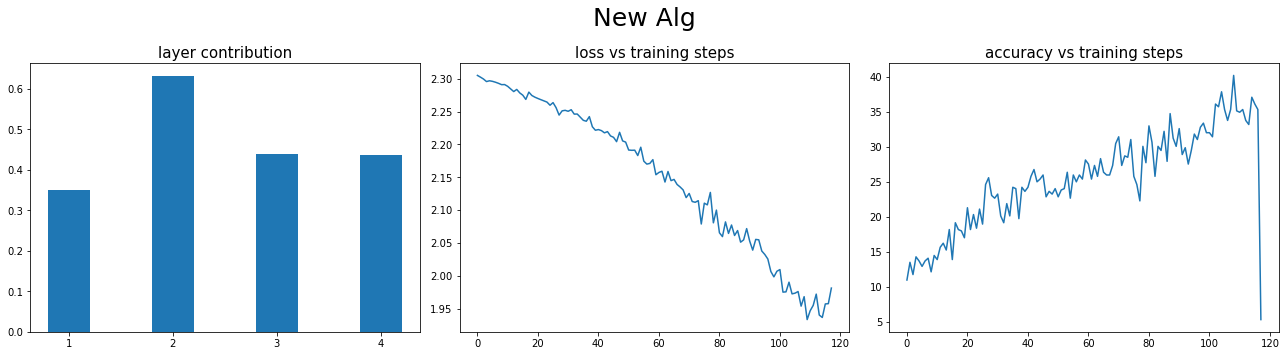

In [144]:
print(Xls[0], Xls[1], Xls[2], Xls[3])
sum = math.fsum(Xls)
print('sum = ', sum)

fig = plt.figure(figsize=(18, 5))
fig.suptitle('New Alg', fontsize=25)

ax = fig.add_subplot(1,3,1)
ax.bar(['1','2','3','4'], [abs(Xls[0]), abs(Xls[1]), abs(Xls[2]) ,abs(Xls[3])], width = 0.4)
ax.set_title('layer contribution', fontsize=15)

x = list(range(len(train_loss)))
ax = fig.add_subplot(1,3,2)
plt.plot(x,train_loss)
ax.set_title('loss vs training steps', fontsize=15)

x = list(range(len(train_accuracy)))
ax = fig.add_subplot(1,3,3)
plt.plot(x,train_accuracy)
ax.set_title('accuracy vs training steps', fontsize=15)

plt.tight_layout()

0.6199042657645354 0.8356459243526283 0.5592469413832349 0.5796116709705937
sum =  2.5944088024709924


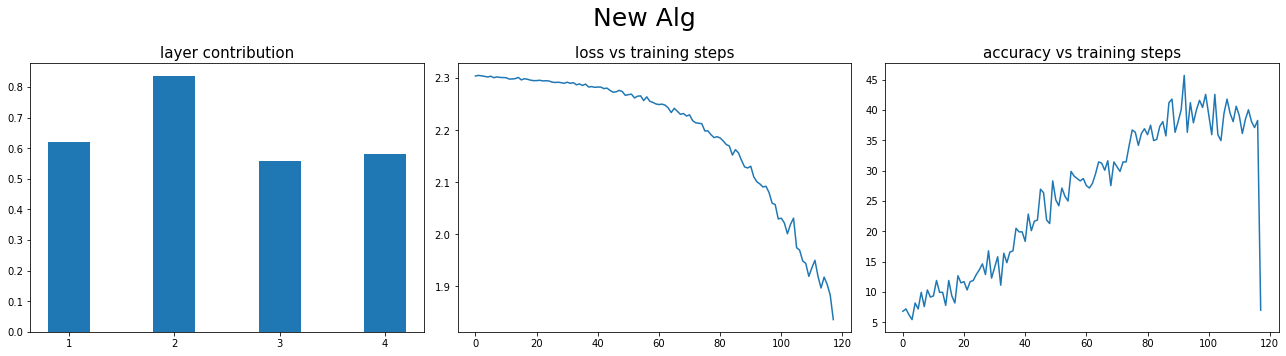

In [ ]:
print(Xls[0], Xls[1], Xls[2], Xls[3])
sum = math.fsum(Xls)
print('sum = ', sum)

fig = plt.figure(figsize=(18, 5))
fig.suptitle('New Alg', fontsize=25)

ax = fig.add_subplot(1,3,1)
ax.bar(['1','2','3','4'], [abs(Xls[0]), abs(Xls[1]), abs(Xls[2]) ,abs(Xls[3])], width = 0.4)
ax.set_title('layer contribution', fontsize=15)

x = list(range(len(train_loss)))
ax = fig.add_subplot(1,3,2)
plt.plot(x,train_loss)
ax.set_title('loss vs training steps', fontsize=15)

x = list(range(len(train_accuracy)))
ax = fig.add_subplot(1,3,3)
plt.plot(x,train_accuracy)
ax.set_title('accuracy vs training steps', fontsize=15)

plt.tight_layout()

In [132]:
# Adam
lr = 1e-2

network = CNN(n_ch, n_classes, final_dim)
Xls, train_loss, train_accuracy = xl_calc_fullt_trained_nn(lr, n_ch, d0, d1, kern_size, pool_size, trainloader, testloader, 'ADAM')

******done training*******


1.3124193081738833 1.1105014940054312 0.9303678523004795 0.8359212115117599
sum =  4.189209865991554


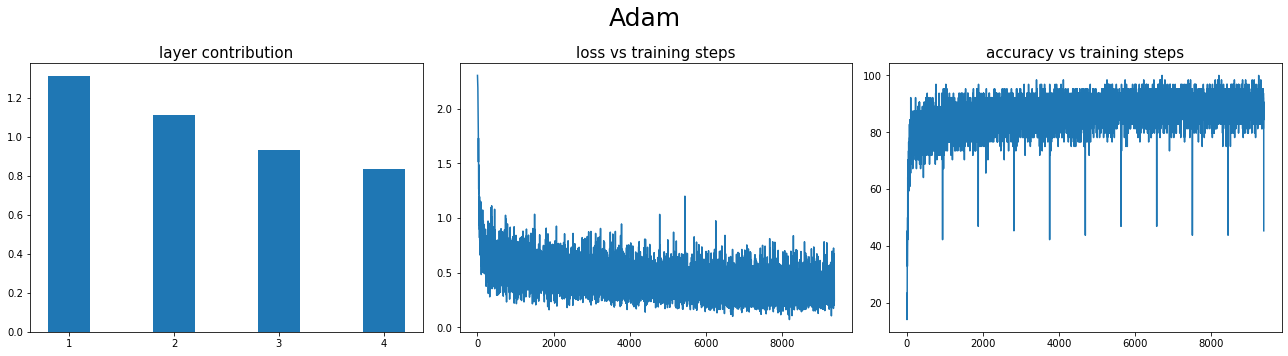

In [133]:
print(Xls[0], Xls[1], Xls[2], Xls[3])
sum = math.fsum(Xls)
print('sum = ', sum)

fig = plt.figure(figsize=(18, 5))
fig.suptitle('Adam', fontsize=25)

ax = fig.add_subplot(1,3,1)
ax.bar(['1','2','3','4'], [abs(Xls[0]), abs(Xls[1]), abs(Xls[2]) ,abs(Xls[3])], width = 0.4)
ax.set_title('layer contribution', fontsize=15)

x = list(range(len(train_loss)))
ax = fig.add_subplot(1,3,2)
plt.plot(x,train_loss)
ax.set_title('loss vs training steps', fontsize=15)

x = list(range(len(train_accuracy)))
ax = fig.add_subplot(1,3,3)
plt.plot(x,train_accuracy)
ax.set_title('accuracy vs training steps', fontsize=15)

plt.tight_layout()